# Tarea 2 - Recuperación de información multimedia
## Gabriel Andrés Azócar Cárcamo

# Parte 1 


# Introducción
En el siguiente notebook se mostrarán los resultados de pruebas de rendimiento de índices tipo KD-Tree y KMeans-tree con diferentes parámetros para siete diferentes tipos de descriptores.
El procedimiento para cada prueba es el siguiente:

1) Se cargan los descriptores.

2) Se hace la búsqueda lineal de los vecinos más cercanos entre datasets.

3) Se genera un kdtree con 10 trees, con el cual se hace nuevamente la búsqueda del vecino más cercano, variando el valor de los checks de la forma 1, 10, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000. Se calcula eficiencia y efectividad de cada una de las pruebas.

4) Se repite el paso 3 pero generando kdtrees con 20, 30, 40 y 50 trees.

5) Se genera un kmeans tree con 10 de valor de branching, con el cual se hace nuevamente la búsqueda del vecino más cercano, variando el valor de los checks de la forma 1, 10, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000. Se calcula eficiencia y efectividad de cada una de las pruebas.

6) Se repite el paso 5 pero generando kmeans trees con 20, 30, 40 y 50 valores de branching.

7) Se muestran los resultados en forma de gráficos y se determina la mejor configuración tomando en cuenta solo la eficiencia y efectividad de esta.

En la sección final del notebook se presentan las conclusiones obtenidas de los pruebas.

Comentario:
Si se desean correr las pruebas en su totalidad, se demora bastante tiempo. Es por eso que trate de encapsular las cosas lo más que pude para que se puedan correr en particular.

## Setup
Primero, se importan los módulos y se crean variables y funciones globales.
Si se quiere cambiar el path de la carpeta de descriptores basta con cambiar el valor de carpeta_descriptores.

In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pyflann
import time

%matplotlib inline

flann = pyflann.FLANN()
carpeta_descriptores = "descriptores/"
checks_intervals = [1, 10, 100, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000]
eficiency_break = 1.3
best_configurations = []

#Clase que agrupa los datos necesarios para comparar resultados
class Result:
    def __init__(self):
        self.name = ""
        self.type = ""
        self.checks = 0
        self.construction_time = 0
        self.search_time = []
        self.eficiency = []
        self.effectiveness = []
        self.dist = 0

    def __str__(self):
        return "Nombre: "+self.name+"\nTipo: "+self.type+"\nTiempo de construcción: "+str(self.construction_time)+"\nTiempo de búsqueda: "+str(self.search_time)+"\nEfeciencia: "+str(self.eficiency)+"\nEfectividad: "+str(self.effectiveness)+"\nCantidad de checks: "+str(self.checks)+"\nCon una distancia euclideana al óptimo de: "+str(self.dist)
        
#Carga un bin de descriptores
def load_file(filename, vector_dimensions):
    mat = numpy.fromfile(filename, dtype=numpy.float32)
    return numpy.reshape(mat, (-1, vector_dimensions))

#Entrega la cantidad de elementos iguales en a y b
def get_matches(a, b):
    c = 0
    i = 0
    while i < len(a):
        if a[i] == b[i]:
            c = c + 1
        i = i + 1
    return float(c)

#Crea un kdtree con la cantidad entregada de arboles e itera sobre el con diferentes checks
def get_kdtree_result(n, t, n_trees, d_r, d_q):
    r = Result()
    r = Result()
    r.name = n
    r.type = t

    t0 = time.time()
    flann.build_index(d_r, algorithm="kdtree", trees=n_trees)
    r.construction_time = time.time() - t0

    for i in checks_intervals:
        t1 = time.time()
        results_search, dists_search = flann.nn_index(d_q, num_neighbors=1, cores=1, checks=i)
        r.search_time.append(time.time() - t1)
        eficiency = float(time.time() - t1) / lineal.search_time
        r.eficiency.append(eficiency)
        r.effectiveness.append(get_matches(results_search, lineal_results_search) / len(results_search))
        
        if eficiency_break < eficiency:
            break
            
    return r

#Crea un kmeans tree con la cantidad entregada de branches e itera sobre el con diferentes checks
def get_kmeans_result(n, t, n_branches, d_r, d_q):
    r = Result()
    r.name = n
    r.type = t

    t0 = time.time()
    flann.build_index(d_r, algorithm="kmeans", branching=n_branches)
    r.construction_time = time.time() - t0

    for i in checks_intervals:
        t1 = time.time()
        results_search, dists_search = flann.nn_index(d_q, num_neighbors=1, cores=1, checks=i)
        r.search_time.append(time.time() - t1)
        eficiency = float(time.time() - t1) / lineal.search_time
        r.eficiency.append(eficiency)
        r.effectiveness.append(get_matches(results_search, lineal_results_search) / len(results_search))
        
        if eficiency_break < eficiency:
            break
            
    return r

#Entrega la distancia euclideana entre el punto [x,y] y el [1,0] (el optimo).
def get_distance_to_optimum(x, y):
    return (x-1)**2 + y**2

#Entrega el indice donde la relacion eficiencia-efectividad en el resultado es mejor y la distancia que este tiene al optimo
#Luego, check_intervals[respuesta] es la mejor configuracion de checks
def get_best_check_configuration(result):
    min_distance = 100
    ind = -1
    i = 0
    while i < len(result.eficiency):
        d = get_distance_to_optimum(result.effectiveness[i], result.eficiency[i])

        if d < min_distance:
            min_distance = d
            ind = i

        i = i + 1

    return ind, min_distance

#Encuentra la mejor configuración entre un arreglo de arboles
def get_best_configuration(trees):
    min_distance = 100
    ind_best = -1
    best_tree = None
    for t in trees:
        i, d = get_best_check_configuration(t)
        
        if d < min_distance:
            min_distance = d
            ind_best = i
            best_tree = t
    
    ans = Result()
    ans.name = best_tree.name
    ans.type = best_tree.type
    ans.checks = checks_intervals[ind_best]
    ans.construction_time = best_tree.construction_time
    ans.search_time = t.search_time[ind_best]
    ans.eficiency = t.eficiency[ind_best]
    ans.effectiveness = t.effectiveness[ind_best]
    ans.dist = min_distance
    
    return ans
    
        
#Muestra los resultados de los experimentos (graficos y mejor configuracion)
#y entrega el Result con la mejor configuración
def show(name, kdtrees, kmtrees):
    #Efectividad vs Eficiencia
    #Plot de kdtrees
    plt.figure(figsize=(15,10))
    plt.plot(kdtrees[0].effectiveness, kdtrees[0].eficiency, '*--')
    plt.plot(kdtrees[1].effectiveness, kdtrees[1].eficiency, '*--')
    plt.plot(kdtrees[2].effectiveness, kdtrees[2].eficiency, '*--')
    plt.plot(kdtrees[3].effectiveness, kdtrees[3].eficiency, '*--')
    plt.plot(kdtrees[4].effectiveness, kdtrees[4].eficiency, '*--')

    plt.title(name + ' usando kdtree')
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kdtrees[0].type, kdtrees[1].type, kdtrees[2].type, kdtrees[3].type, kdtrees[4].type])
    plt.show()
    
    #Best kdtree
    best_kdtree = get_best_configuration(kdtrees)
    print('MEJOR KDTREE')
    print(best_kdtree)
    
    #Plot de kmtrees
    plt.figure(figsize=(15,10))
    plt.plot(kmtrees[0].effectiveness, kmtrees[0].eficiency, '*--')
    plt.plot(kmtrees[1].effectiveness, kmtrees[1].eficiency, '*--')
    plt.plot(kmtrees[2].effectiveness, kmtrees[2].eficiency, '*--')
    plt.plot(kmtrees[3].effectiveness, kmtrees[3].eficiency, '*--')
    plt.plot(kmtrees[4].effectiveness, kmtrees[4].eficiency, '*--')

    plt.title(name + ' usando kmeans trees')
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kmtrees[0].type, kmtrees[1].type, kmtrees[2].type, kmtrees[3].type, kmtrees[4].type])
    plt.show()
    
    #Best kmtree
    best_kmtree = get_best_configuration(kmtrees)
    print('MEJOR KMEANS TREE')
    print(best_kmtree)
    
    #Global
    plt.figure(figsize=(15,10))
    plt.plot(kdtrees[0].effectiveness, kdtrees[0].eficiency, '*--')
    plt.plot(kdtrees[1].effectiveness, kdtrees[1].eficiency, '*--')
    plt.plot(kdtrees[2].effectiveness, kdtrees[2].eficiency, '*--')
    plt.plot(kdtrees[3].effectiveness, kdtrees[3].eficiency, '*--')
    plt.plot(kdtrees[4].effectiveness, kdtrees[4].eficiency, '*--')
    plt.plot(kmtrees[0].effectiveness, kmtrees[0].eficiency, '*--')
    plt.plot(kmtrees[1].effectiveness, kmtrees[1].eficiency, '*--')
    plt.plot(kmtrees[2].effectiveness, kmtrees[2].eficiency, '*--')
    plt.plot(kmtrees[3].effectiveness, kmtrees[3].eficiency, '*--')
    plt.plot(kmtrees[4].effectiveness, kmtrees[4].eficiency, '*--')

    plt.title(name)
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kdtrees[0].type, kdtrees[1].type, kdtrees[2].type, kdtrees[3].type, kdtrees[4].type, kmtrees[0].type, kmtrees[1].type, kmtrees[2].type, kmtrees[3].type, kmtrees[4].type])
    plt.show()
    
    #Mejor configuracion
    if best_kmtree.dist < best_kdtree.dist:
        best_configuration = best_kmtree
    else:
        best_configuration = best_kdtree
    print('MEJOR CONFIGURACION')
    print(best_configuration)
    return best_configuration

# Análisis de 1-IMGRAY_16X9

Carga de descriptores y creación de estructuras de datos.

In [165]:
dataset_r = load_file(carpeta_descriptores+"1-IMGRAY_16X9/R-35798_144_4F.bin", 144)
dataset_q = load_file(carpeta_descriptores+"1-IMGRAY_16X9/Q-7201_144_4F.bin", 144)

In [166]:
#Busqueda lineal
lineal = Result()
lineal.name = "1-IMGRAY_16X9"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [168]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_1 = get_kdtree_result("1-IMGRAY_16X9", "kdtree-10", 10, dataset_r, dataset_q)

In [169]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_1 = get_kdtree_result("1-IMGRAY_16X9", "kdtree-20", 20, dataset_r, dataset_q)

In [170]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_1 = get_kdtree_result("1-IMGRAY_16X9", "kdtree-30", 30, dataset_r, dataset_q)

In [171]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_1 = get_kdtree_result("1-IMGRAY_16X9", "kdtree-40", 40, dataset_r, dataset_q)

In [172]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_1 = get_kdtree_result("1-IMGRAY_16X9", "kdtree-50", 50, dataset_r, dataset_q)

In [173]:
kdtrees_1 = [kdtree_10_1, kdtree_20_1, kdtree_30_1, kdtree_40_1, kdtree_50_1]

## Usando K-Means Tree

In [174]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_1 = get_kmeans_result("1-IMGRAY_16X9", "kmtree-10", 10, dataset_r, dataset_q)

In [175]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_1 = get_kmeans_result("1-IMGRAY_16X9", "kmtree-20", 20, dataset_r, dataset_q)

In [176]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_1 = get_kmeans_result("1-IMGRAY_16X9", "kmtree-30", 30, dataset_r, dataset_q)

In [177]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_1 = get_kmeans_result("1-IMGRAY_16X9", "kmtree-40", 40, dataset_r, dataset_q)

In [178]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_1 = get_kmeans_result("1-IMGRAY_16X9", "kmtree-50", 50, dataset_r, dataset_q)

In [179]:
kmtrees_1 = [kmtree_10_1, kmtree_20_1, kmtree_30_1, kmtree_40_1, kmtree_50_1]

## Gráficos y resultados

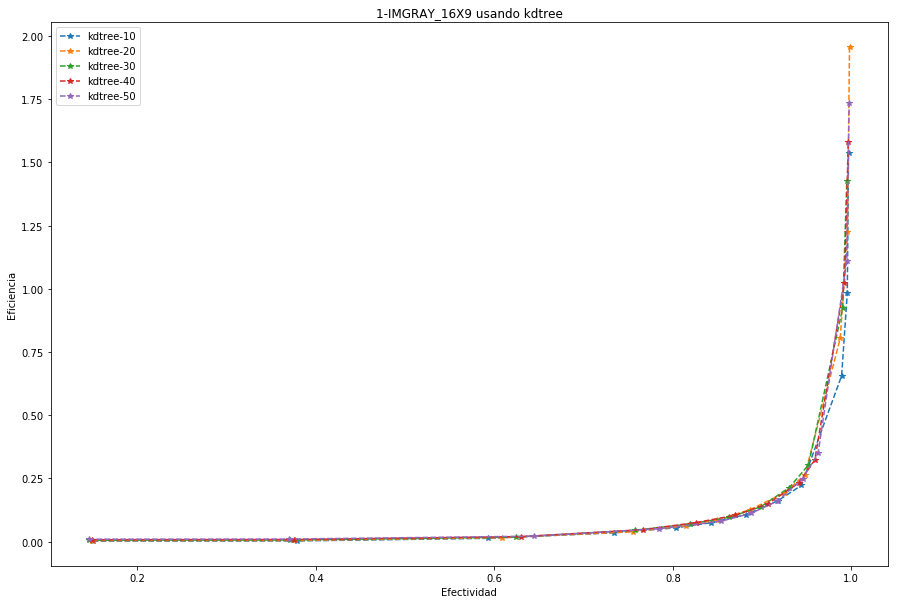

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9
Tipo: kdtree-50
Tiempo de construcción: 5.024856328964233
Tiempo de búsqueda: 3.0419044494628906
Efeciencia: 0.1113415831379498
Efectividad: 0.8873767532287182
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.025080943848970017


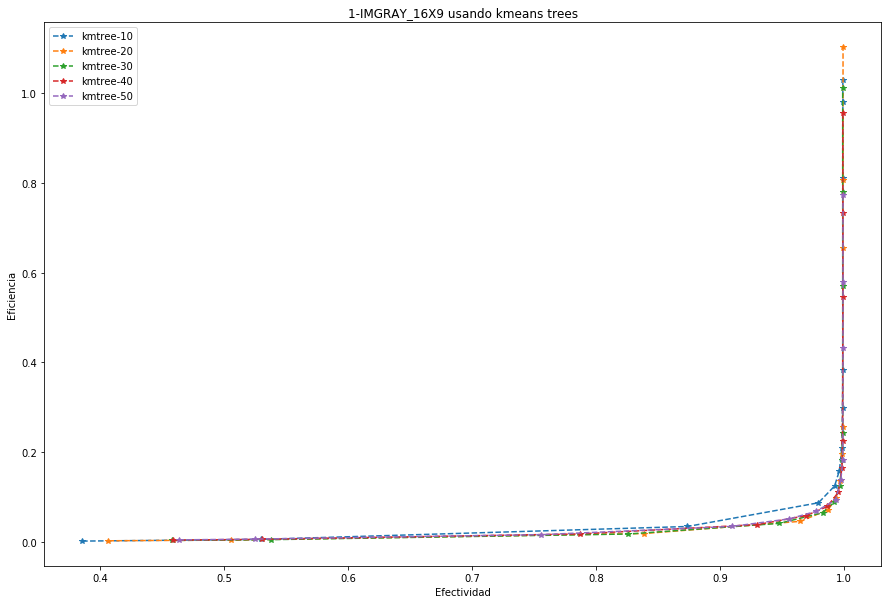

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9
Tipo: kmtree-20
Tiempo de construcción: 2.257634401321411
Tiempo de búsqueda: 0.9545691013336182
Efeciencia: 0.03493974989936114
Efectividad: 0.909457019858353
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.003389744126446868


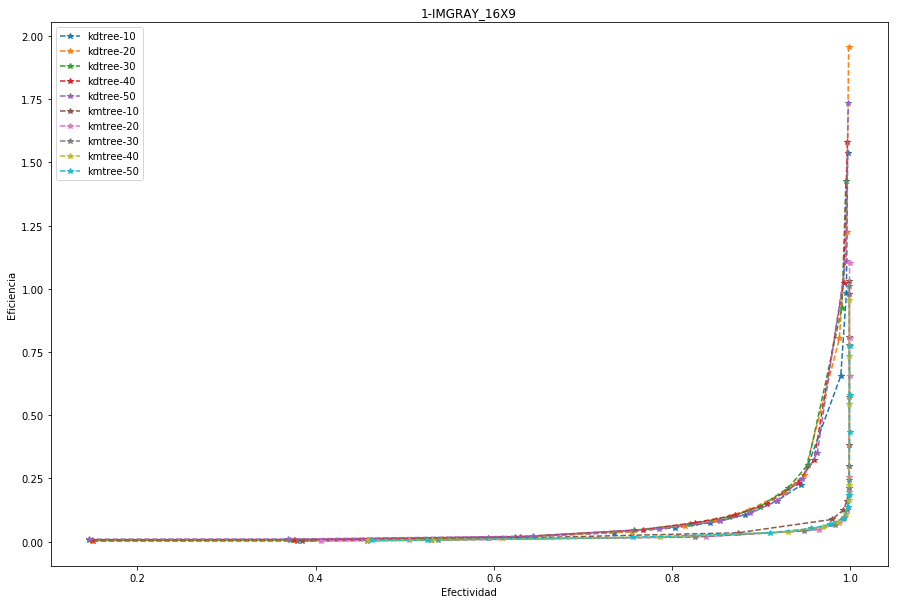

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9
Tipo: kmtree-20
Tiempo de construcción: 2.257634401321411
Tiempo de búsqueda: 0.9545691013336182
Efeciencia: 0.03493974989936114
Efectividad: 0.909457019858353
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.003389744126446868


In [359]:
best_configurations.append(show('1-IMGRAY_16X9', kdtrees_1, kmtrees_1))

# Análisis de 1-IMGRAY_16X9_AVG

Carga de descriptores y creación de estructuras de datos.


In [186]:
dataset_r = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/R-35798_144_4F.bin", 144)
dataset_q = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/Q-7201_144_4F.bin", 144)

In [187]:
#Busqueda lineal
lineal = Result()
lineal.name = "1-IMGRAY_16X9_AVG"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [189]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_2 = get_kdtree_result("1-IMGRAY_16X9_AVG", "kdtree-10", 10, dataset_r, dataset_q)

In [190]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_2 = get_kdtree_result("1-IMGRAY_16X9_AVG", "kdtree-20", 20, dataset_r, dataset_q)

In [191]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_2 = get_kdtree_result("1-IMGRAY_16X9_AVG", "kdtree-30", 30, dataset_r, dataset_q)

In [192]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_2 = get_kdtree_result("1-IMGRAY_16X9_AVG", "kdtree-40", 40, dataset_r, dataset_q)

In [193]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_2 = get_kdtree_result("1-IMGRAY_16X9_AVG", "kdtree-50", 50, dataset_r, dataset_q)

In [194]:
kdtrees_2 = [kdtree_10_2, kdtree_20_2, kdtree_30_2, kdtree_40_2, kdtree_50_2]

## Usando K-Means Tree

In [195]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_2 = get_kmeans_result("1-IMGRAY_16X9_AVG", "kmtree-10", 10, dataset_r, dataset_q)

In [196]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_2 = get_kmeans_result("1-IMGRAY_16X9_AVG", "kmtree-20", 20, dataset_r, dataset_q)

In [197]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_2 = get_kmeans_result("1-IMGRAY_16X9_AVG", "kmtree-30", 30, dataset_r, dataset_q)

In [198]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_2 = get_kmeans_result("1-IMGRAY_16X9_AVG", "kmtree-40", 40, dataset_r, dataset_q)

In [199]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_2 = get_kmeans_result("1-IMGRAY_16X9_AVG", "kmtree-50", 50, dataset_r, dataset_q)

In [200]:
kmtrees_2 = [kmtree_10_2, kmtree_20_2, kmtree_30_2, kmtree_40_2, kmtree_50_2]

## Gráficos y resultados

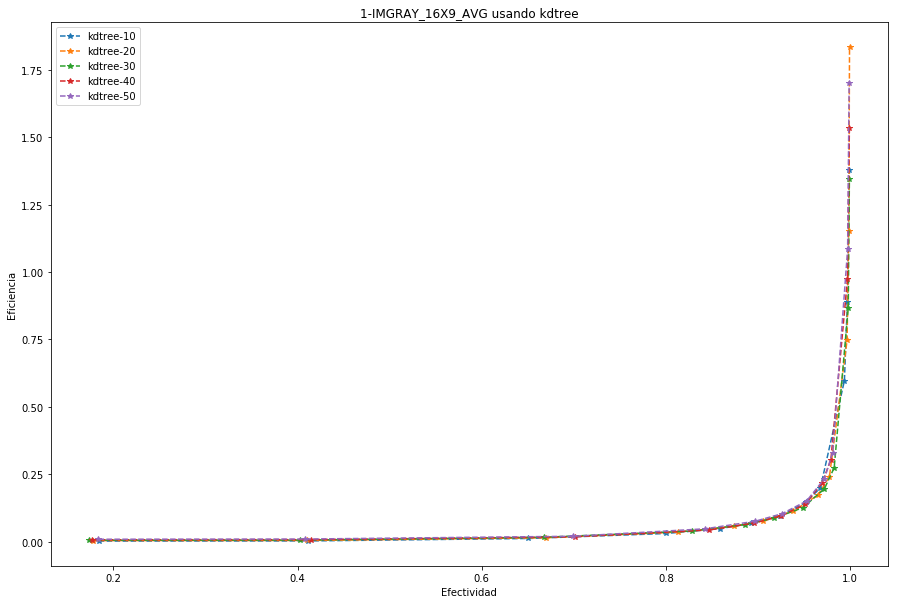

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9_AVG
Tipo: kdtree-30
Tiempo de construcción: 3.1740846633911133
Tiempo de búsqueda: 3.1153757572174072
Efeciencia: 0.1034192624606632
Efectividad: 0.9262602416331065
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.014313947262308998


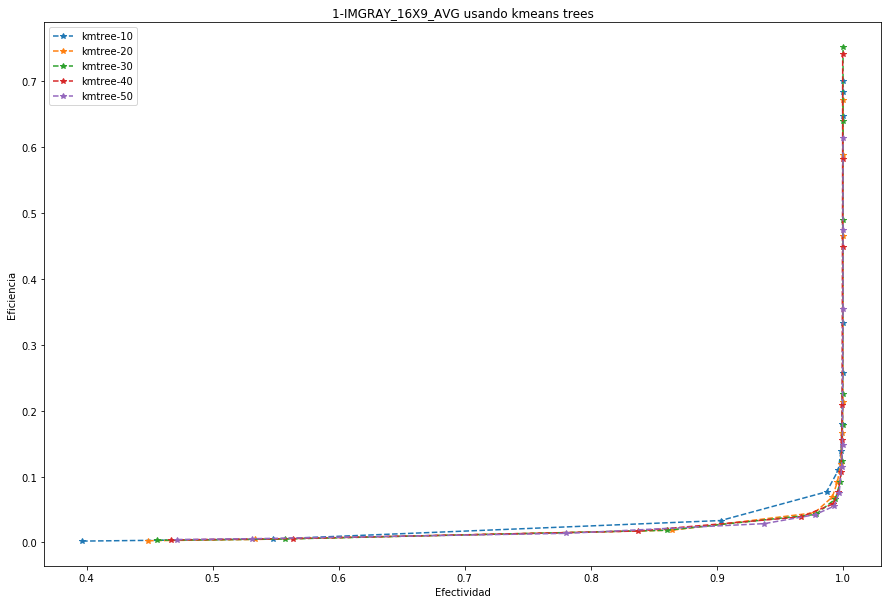

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9_AVG
Tipo: kmtree-50
Tiempo de construcción: 3.8618037700653076
Tiempo de búsqueda: 1.2658696174621582
Efeciencia: 0.04202236372510392
Efectividad: 0.9776419941674768
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0022657594778520726


MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9_AVG
Tipo: kmtree-50
Tiempo de construcción: 3.8618037700653076
Tiempo de búsqueda: 1.2658696174621582
Efeciencia: 0.04202236372510392
Efectividad: 0.9776419941674768
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0022657594778520726


In [360]:
best_configurations.append(show('1-IMGRAY_16X9_AVG', kdtrees_2, kmtrees_2))

# Análisis de 2-MEL_16000_80_64_32

Carga de descriptores y creación de estructuras de datos.

In [202]:
dataset_r = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/R-35798_80_4F.bin", 80)
dataset_q = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/Q-7201_80_4F.bin", 80)

In [203]:
#Busqueda lineal
lineal = Result()
lineal.name = "2-MEL_16000_80_64_32"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [205]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_3 = get_kdtree_result("2-MEL_16000_80_64_32", "kdtree-10", 10, dataset_r, dataset_q)

In [206]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_20_3 = get_kdtree_result("2-MEL_16000_80_64_32", "kdtree-20", 20, dataset_r, dataset_q)

In [207]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_30_3 = get_kdtree_result("2-MEL_16000_80_64_32", "kdtree-30", 30, dataset_r, dataset_q)

In [208]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_40_3 = get_kdtree_result("2-MEL_16000_80_64_32", "kdtree-40", 40, dataset_r, dataset_q)

In [209]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_50_3 = get_kdtree_result("2-MEL_16000_80_64_32", "kdtree-50", 50, dataset_r, dataset_q)

In [210]:
kdtrees_3 = [kdtree_10_3, kdtree_20_3, kdtree_30_3, kdtree_40_3, kdtree_50_3]

## Usando K-Means Tree

In [211]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_3 = get_kmeans_result("2-MEL_16000_80_64_32", "kmtree-10", 10, dataset_r, dataset_q)

In [212]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_3 = get_kmeans_result("2-MEL_16000_80_64_32", "kmtree-20", 20, dataset_r, dataset_q)

In [213]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_3 = get_kmeans_result("2-MEL_16000_80_64_32", "kmtree-30", 30, dataset_r, dataset_q)

In [214]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_3 = get_kmeans_result("2-MEL_16000_80_64_32", "kmtree-40", 40, dataset_r, dataset_q)

In [215]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_3 = get_kmeans_result("2-MEL_16000_80_64_32", "kmtree-50", 50, dataset_r, dataset_q)

In [216]:
kmtrees_3 = [kmtree_10_3, kmtree_20_3, kmtree_30_3, kmtree_40_3, kmtree_50_3]

## Gráficos y resultados

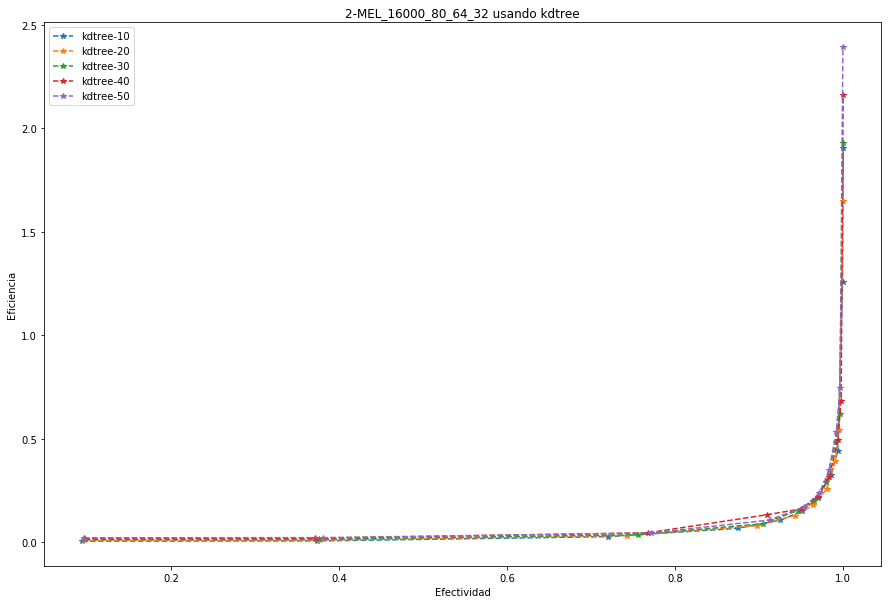

MEJOR KDTREE
Nombre: 2-MEL_16000_80_64_32
Tipo: kdtree-20
Tiempo de construcción: 1.2834854125976562
Tiempo de búsqueda: 1.5682756900787354
Efeciencia: 0.10570487842191466
Efectividad: 0.9123732814886821
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.016717262838778287


MEJOR KMEANS TREE
Nombre: 2-MEL_16000_80_64_32
Tipo: kmtree-50
Tiempo de construcción: 2.0660247802734375
Tiempo de búsqueda: 0.9050934314727783
Efeciencia: 0.061005101857160855
Efectividad: 0.9412581585890849
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.00717222638494767


MEJOR CONFIGURACION
Nombre: 2-MEL_16000_80_64_32
Tipo: kmtree-50
Tiempo de construcción: 2.0660247802734375
Tiempo de búsqueda: 0.9050934314727783
Efeciencia: 0.061005101857160855
Efectividad: 0.9412581585890849
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.00717222638494767


In [361]:
best_configurations.append(show('2-MEL_16000_80_64_32', kdtrees_3, kmtrees_3))

# Análisis de 3-ALEXNET_FC7

Carga de descriptores y creación de estructuras de datos.

In [218]:
dataset_r = load_file(carpeta_descriptores+"3-ALEXNET_FC7/R-35798_4096_4F.bin", 4096)
dataset_q = load_file(carpeta_descriptores+"3-ALEXNET_FC7/Q-7201_4096_4F.bin", 4096)

In [219]:
#Busqueda lineal
lineal = Result()
lineal.name = "3-ALEXNET_FC7"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [221]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_4 = get_kdtree_result("3-ALEXNET_FC7", "kdtree-10", 10, dataset_r, dataset_q)

In [222]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_20_4 = get_kdtree_result("3-ALEXNET_FC7", "kdtree-20", 20, dataset_r, dataset_q)

In [223]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_30_4 = get_kdtree_result("3-ALEXNET_FC7", "kdtree-30", 30, dataset_r, dataset_q)

In [224]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_40_4 = get_kdtree_result("3-ALEXNET_FC7", "kdtree-40", 40, dataset_r, dataset_q)

In [225]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_50_4 = get_kdtree_result("3-ALEXNET_FC7", "kdtree-50", 50, dataset_r, dataset_q)

In [226]:
kdtrees_4 = [kdtree_10_4, kdtree_20_4, kdtree_30_4, kdtree_40_4, kdtree_50_4]

## Usando K-Means Tree

In [227]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_4 = get_kmeans_result("3-ALEXNET_FC7", "kmtree-10", 10, dataset_r, dataset_q)

In [228]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_4 = get_kmeans_result("3-ALEXNET_FC7", "kmtree-20", 20, dataset_r, dataset_q)

In [229]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_4 = get_kmeans_result("3-ALEXNET_FC7", "kmtree-30", 30, dataset_r, dataset_q)

In [230]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_4 = get_kmeans_result("3-ALEXNET_FC7", "kmtree-40", 40, dataset_r, dataset_q)

In [231]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_4 = get_kmeans_result("3-ALEXNET_FC7", "kmtree-50", 50, dataset_r, dataset_q)

In [232]:
kmtrees_4 = [kmtree_10_4, kmtree_20_4, kmtree_30_4, kmtree_40_4, kmtree_50_4]

## Gráficos y resultados

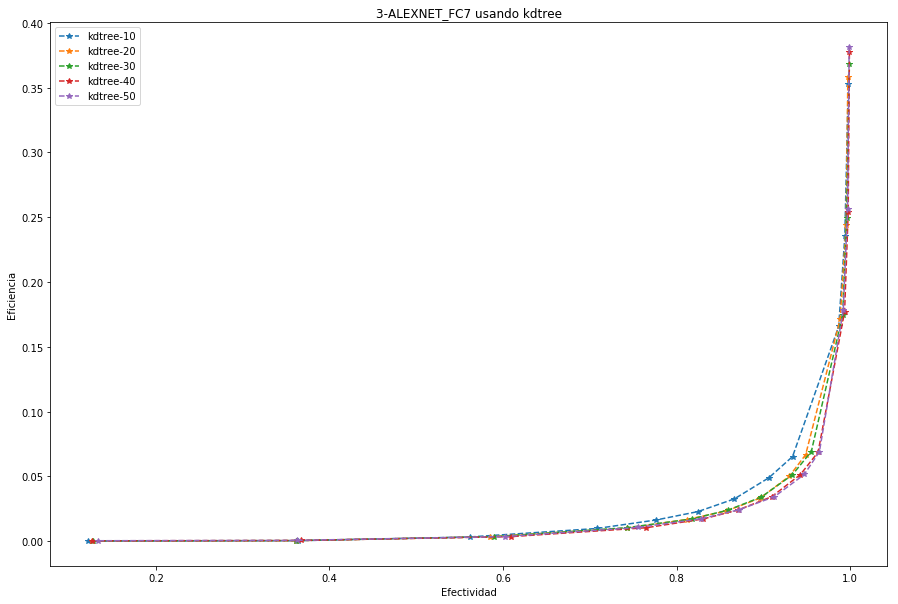

MEJOR KDTREE
Nombre: 3-ALEXNET_FC7
Tipo: kdtree-50
Tiempo de construcción: 88.77735710144043
Tiempo de búsqueda: 38.892064809799194
Efeciencia: 0.05158713140608579
Efectividad: 0.9473684210526315
Cantidad de checks: 1500
Con una distancia euclideana al óptimo de: 0.005431315229201844


MEJOR KMEANS TREE
Nombre: 3-ALEXNET_FC7
Tipo: kmtree-50
Tiempo de construcción: 103.20842051506042
Tiempo de búsqueda: 73.09483623504639
Efeciencia: 0.09695429760646605
Efectividad: 0.8990417997500347
Cantidad de checks: 1000
Con una distancia euclideana al óptimo de: 0.019592694022075276


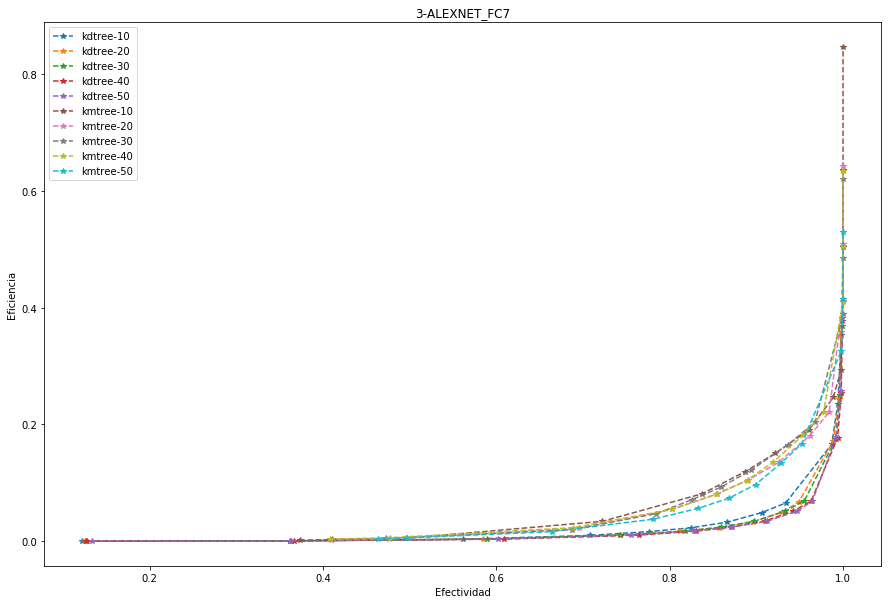

MEJOR CONFIGURACION
Nombre: 3-ALEXNET_FC7
Tipo: kdtree-50
Tiempo de construcción: 88.77735710144043
Tiempo de búsqueda: 38.892064809799194
Efeciencia: 0.05158713140608579
Efectividad: 0.9473684210526315
Cantidad de checks: 1500
Con una distancia euclideana al óptimo de: 0.005431315229201844


In [362]:
best_configurations.append(show('3-ALEXNET_FC7', kdtrees_4, kmtrees_4))

# Análisis de 3-VGG_FC7

Carga de descriptores y creación de estructuras de datos.

In [235]:
dataset_r = load_file(carpeta_descriptores+"3-VGG_FC7/R-35798_4096_4F.bin", 4096)
dataset_q = load_file(carpeta_descriptores+"3-VGG_FC7/Q-7201_4096_4F.bin", 4096)

In [236]:
#Busqueda lineal
lineal = Result()
lineal.name = "3-VGG_FC7"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [238]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_5 = get_kdtree_result("3-VGG_FC7", "kdtree-10", 10, dataset_r, dataset_q)

In [239]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_20_5 = get_kdtree_result("3-VGG_FC7", "kdtree-20", 20, dataset_r, dataset_q)

In [240]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_30_5 = get_kdtree_result("3-VGG_FC7", "kdtree-30", 30, dataset_r, dataset_q)

In [241]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_40_5 = get_kdtree_result("3-VGG_FC7", "kdtree-40", 40, dataset_r, dataset_q)

In [242]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_50_5 = get_kdtree_result("3-VGG_FC7", "kdtree-50", 50, dataset_r, dataset_q)

In [243]:
kdtrees_5 = [kdtree_10_5, kdtree_20_5, kdtree_30_5, kdtree_40_5, kdtree_50_5]

## Usando K-Means Tree

In [244]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_5 = get_kmeans_result("3-VGG_FC7", "kmtree-10", 10, dataset_r, dataset_q)

In [245]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_5 = get_kmeans_result("3-VGG_FC7", "kmtree-20", 20, dataset_r, dataset_q)

In [246]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_5 = get_kmeans_result("3-VGG_FC7", "kmtree-30", 30, dataset_r, dataset_q)

In [247]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_5 = get_kmeans_result("3-VGG_FC7", "kmtree-40", 40, dataset_r, dataset_q)

In [248]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_5 = get_kmeans_result("3-VGG_FC7", "kmtree-50", 50, dataset_r, dataset_q)

In [249]:
kmtrees_5 = [kmtree_10_5, kmtree_20_5, kmtree_30_5, kmtree_40_5, kmtree_50_5]

## Gráficos y resultados

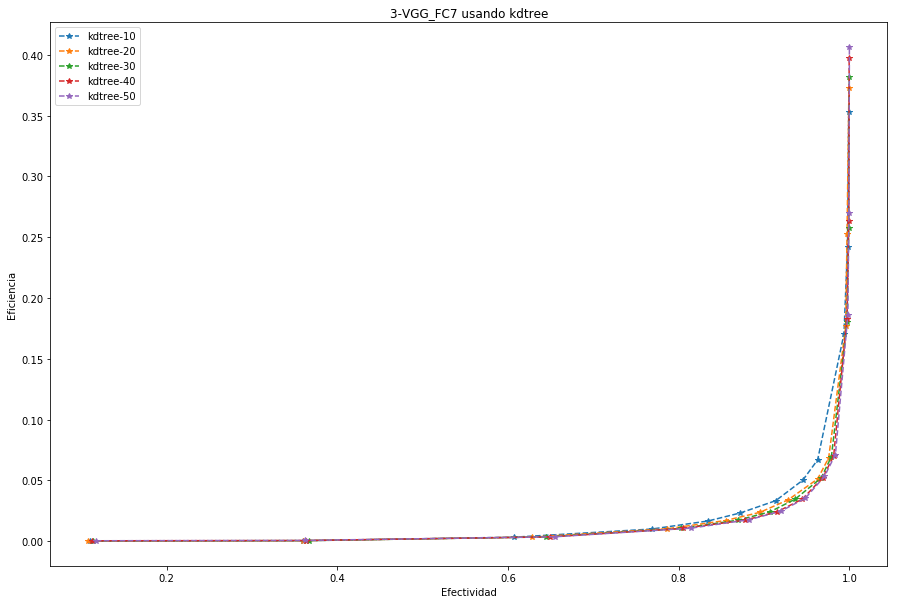

MEJOR KDTREE
Nombre: 3-VGG_FC7
Tipo: kdtree-50
Tiempo de construcción: 96.99212956428528
Tiempo de búsqueda: 45.23457884788513
Efeciencia: 0.05323330970079644
Efectividad: 0.9706985140952645
Cantidad de checks: 1500
Con una distancia euclideana al óptimo de: 0.00369236233792632


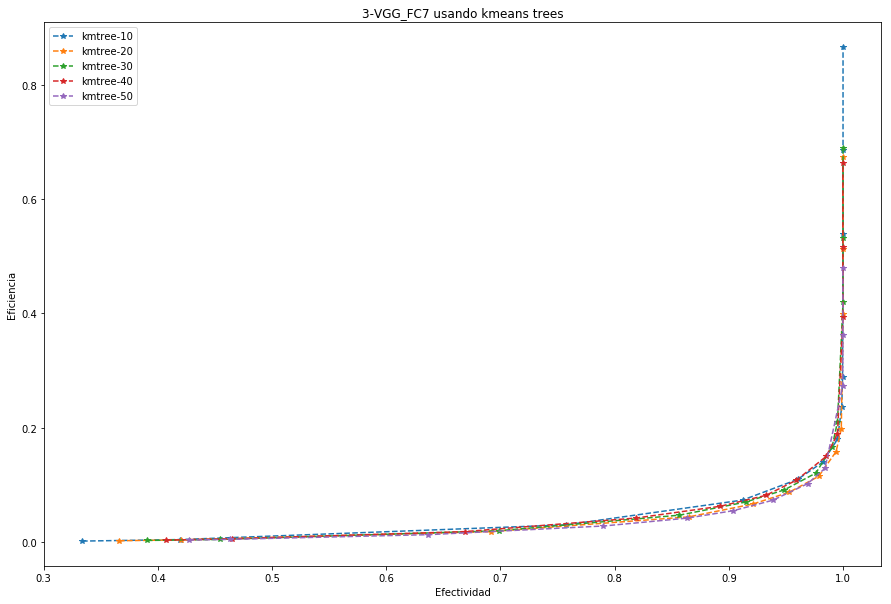

MEJOR KMEANS TREE
Nombre: 3-VGG_FC7
Tipo: kmtree-50
Tiempo de construcción: 102.3380835056305
Tiempo de búsqueda: 62.19462060928345
Efeciencia: 0.07319235752013772
Efectividad: 0.9386196361616442
Cantidad de checks: 1000
Con una distancia euclideana al óptimo de: 0.009124670264284594


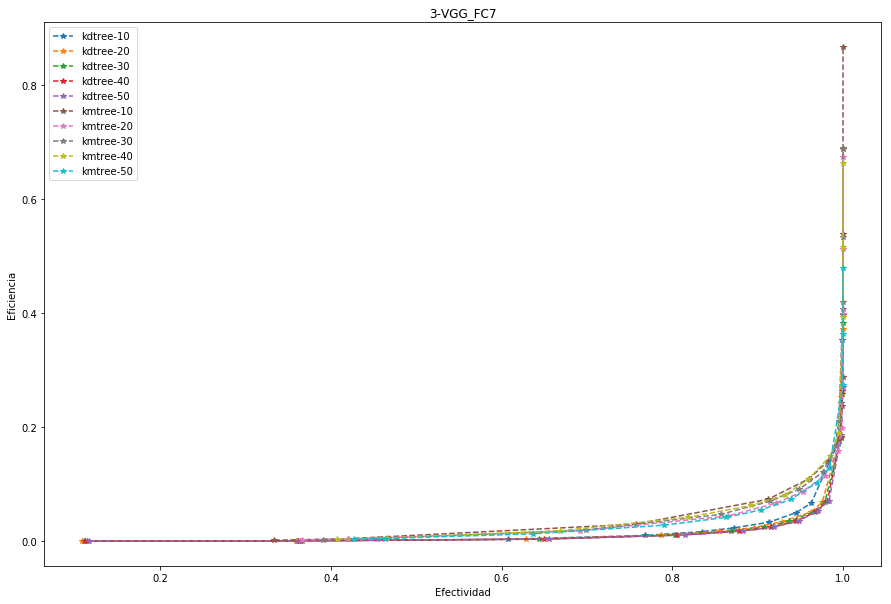

MEJOR CONFIGURACION
Nombre: 3-VGG_FC7
Tipo: kdtree-50
Tiempo de construcción: 96.99212956428528
Tiempo de búsqueda: 45.23457884788513
Efeciencia: 0.05323330970079644
Efectividad: 0.9706985140952645
Cantidad de checks: 1500
Con una distancia euclideana al óptimo de: 0.00369236233792632


In [363]:
best_configurations.append(show('3-VGG_FC7', kdtrees_5, kmtrees_5))

# Análisis de 4-SIFT_240_1

Carga de descriptores y creación de estructuras de datos.

In [251]:
dataset_r = load_file(carpeta_descriptores+"4-SIFT_240_1/R-35798_128_4F.bin", 128)
dataset_q = load_file(carpeta_descriptores+"4-SIFT_240_1/Q-7201_128_4F.bin", 128)

In [252]:
#Busqueda lineal
lineal = Result()
lineal.name = "4-SIFT_240_1"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [254]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_6 = get_kdtree_result("4-SIFT_240_1", "kdtree-10", 10, dataset_r, dataset_q)

In [255]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_20_6 = get_kdtree_result("4-SIFT_240_1", "kdtree-20", 20, dataset_r, dataset_q)

In [256]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_30_6 = get_kdtree_result("4-SIFT_240_1", "kdtree-30", 30, dataset_r, dataset_q)

In [257]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_40_6 = get_kdtree_result("4-SIFT_240_1", "kdtree-40", 40, dataset_r, dataset_q)

In [258]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_50_6 = get_kdtree_result("4-SIFT_240_1", "kdtree-50", 50, dataset_r, dataset_q)

In [259]:
kdtrees_6 = [kdtree_10_6, kdtree_20_6, kdtree_30_6, kdtree_40_6, kdtree_50_6]

## Usando K-Means Tree

In [260]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_6 = get_kmeans_result("4-SIFT_240_1", "kmtree-10", 10, dataset_r, dataset_q)

In [261]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_6 = get_kmeans_result("4-SIFT_240_1", "kmtree-20", 20, dataset_r, dataset_q)

In [262]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_6 = get_kmeans_result("4-SIFT_240_1", "kmtree-30", 30, dataset_r, dataset_q)

In [263]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_6 = get_kmeans_result("4-SIFT_240_1", "kmtree-40", 40, dataset_r, dataset_q)

In [264]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_6 = get_kmeans_result("4-SIFT_240_1", "kmtree-50", 50, dataset_r, dataset_q)

In [265]:
kmtrees_6 = [kmtree_10_6, kmtree_20_6, kmtree_30_6, kmtree_40_6, kmtree_50_6]

## Gráficos y resultados

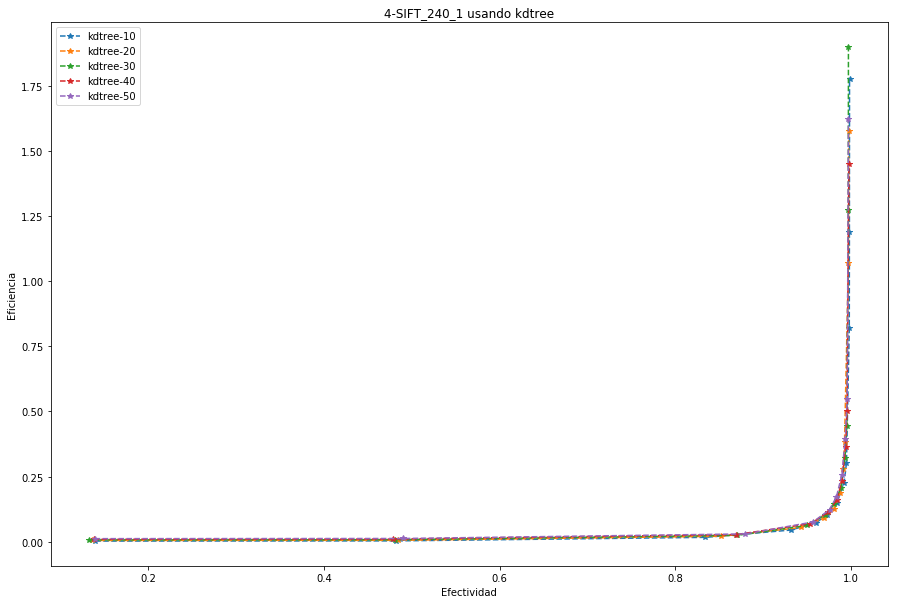

MEJOR KDTREE
Nombre: 4-SIFT_240_1
Tipo: kdtree-20
Tiempo de construcción: 1.9440155029296875
Tiempo de búsqueda: 1.7848122119903564
Efeciencia: 0.07574373359274487
Efectividad: 0.9566726843493959
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.006192083030293522


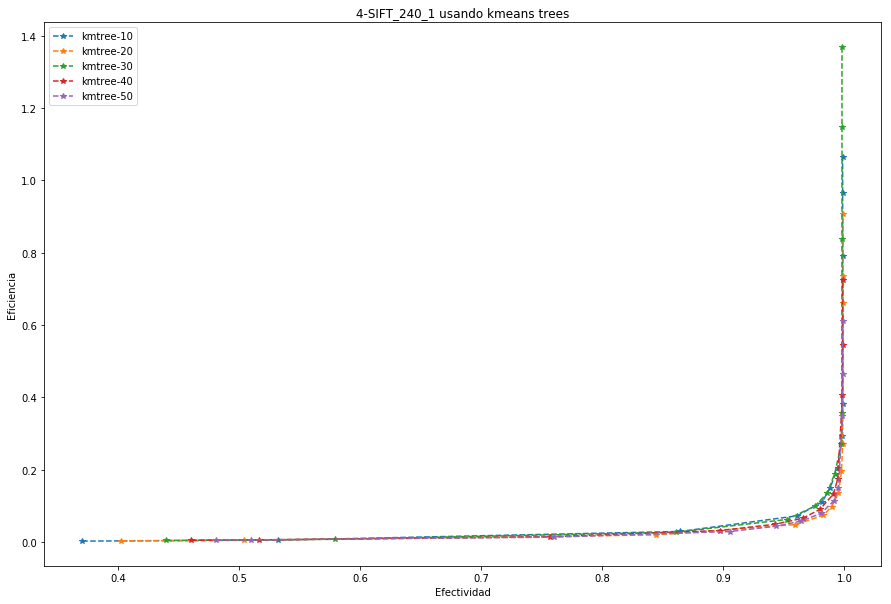

MEJOR KMEANS TREE
Nombre: 4-SIFT_240_1
Tipo: kmtree-20
Tiempo de construcción: 1.985621690750122
Tiempo de búsqueda: 0.6764981746673584
Efeciencia: 0.02870924559370771
Efectividad: 0.9051520622135815
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.003965428500196433


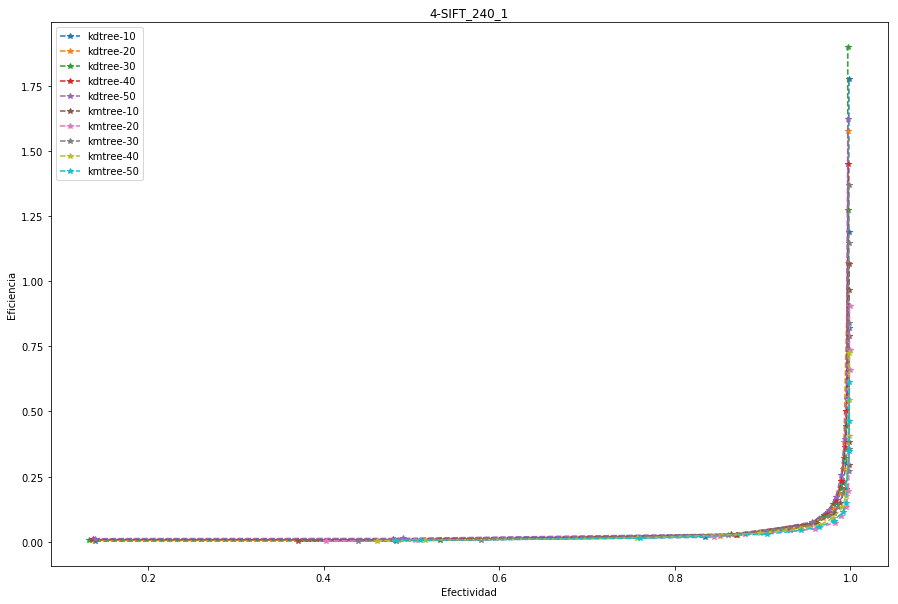

MEJOR CONFIGURACION
Nombre: 4-SIFT_240_1
Tipo: kmtree-20
Tiempo de construcción: 1.985621690750122
Tiempo de búsqueda: 0.6764981746673584
Efeciencia: 0.02870924559370771
Efectividad: 0.9051520622135815
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.003965428500196433


In [364]:
best_configurations.append(show('4-SIFT_240_1', kdtrees_6, kmtrees_6))

# Análisis de 4-SURF_240_1

Carga de descriptores y creación de estructuras de datos.

In [268]:
dataset_r = load_file(carpeta_descriptores+"4-SURF_240_1/R-35798_64_4F.bin", 64)
dataset_q = load_file(carpeta_descriptores+"4-SURF_240_1/Q-7201_64_4F.bin", 64)

In [269]:
#Busqueda lineal
lineal = Result()
lineal.name = "4-SURF_240_1"
lineal.type = "LINEAL"

t0 = time.time()
flann.build_index(dataset_r, algorithm="linear")
lineal.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
lineal.search_time = time.time() - t0

lineal_results_search = results_search
lineal_dists_search = dists_search

## Usando Randomized KD-Tree

In [271]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_7 = get_kdtree_result("4-SURF_240_1", "kdtree-10", 10, dataset_r, dataset_q)

In [272]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_20_7 = get_kdtree_result("4-SURF_240_1", "kdtree-20", 20, dataset_r, dataset_q)

In [273]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_30_7 = get_kdtree_result("4-SURF_240_1", "kdtree-30", 30, dataset_r, dataset_q)

In [274]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_40_7 = get_kdtree_result("4-SURF_240_1", "kdtree-40", 40, dataset_r, dataset_q)

In [275]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_50_7 = get_kdtree_result("4-SURF_240_1", "kdtree-50", 50, dataset_r, dataset_q)

In [276]:
kdtrees_7 = [kdtree_10_7, kdtree_20_7, kdtree_30_7, kdtree_40_7, kdtree_50_7]

## Usando K-Means Tree

In [277]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_7 = get_kmeans_result("4-SURF_240_1", "kmtree-10", 10, dataset_r, dataset_q)

In [278]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_20_7 = get_kmeans_result("4-SURF_240_1", "kmtree-20", 20, dataset_r, dataset_q)

In [279]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_30_7 = get_kmeans_result("4-SURF_240_1", "kmtree-30", 30, dataset_r, dataset_q)

In [280]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_40_7 = get_kmeans_result("4-SURF_240_1", "kmtree-40", 40, dataset_r, dataset_q)

In [281]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_50_7 = get_kmeans_result("4-SURF_240_1", "kmtree-50", 50, dataset_r, dataset_q)

In [282]:
kmtrees_7 = [kmtree_10_7, kmtree_20_7, kmtree_30_7, kmtree_40_7, kmtree_50_7]

## Gráficos y resultados

MEJOR KDTREE
Nombre: 4-SURF_240_1
Tipo: kdtree-10
Tiempo de construcción: 0.627877950668335
Tiempo de búsqueda: 2.0810139179229736
Efeciencia: 0.15257239369559653
Efectividad: 0.9841688654353562
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.008219822646291895


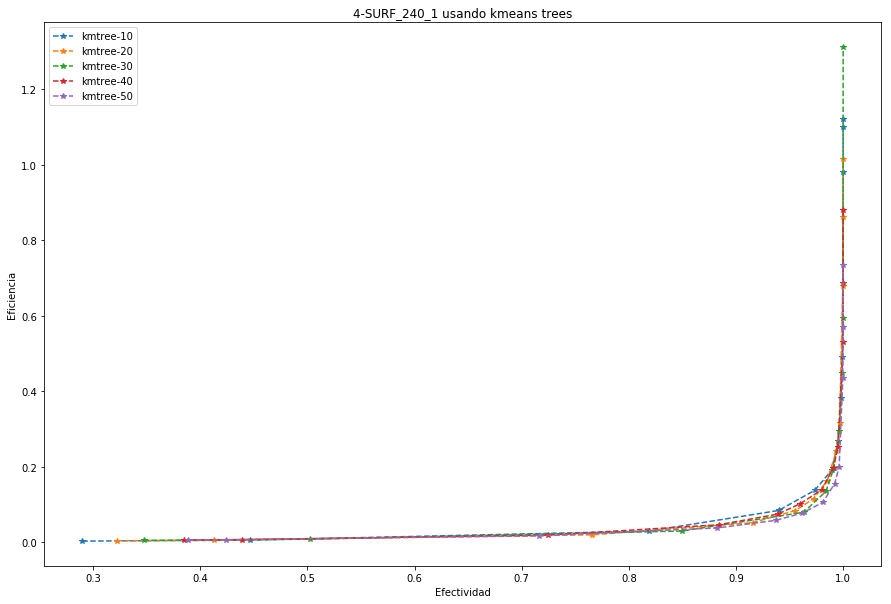

MEJOR KMEANS TREE
Nombre: 4-SURF_240_1
Tipo: kmtree-50
Tiempo de construcción: 1.6935081481933594
Tiempo de búsqueda: 0.7948737144470215
Efeciencia: 0.058277386207963314
Efectividad: 0.9372309401472018
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0073362086180362805


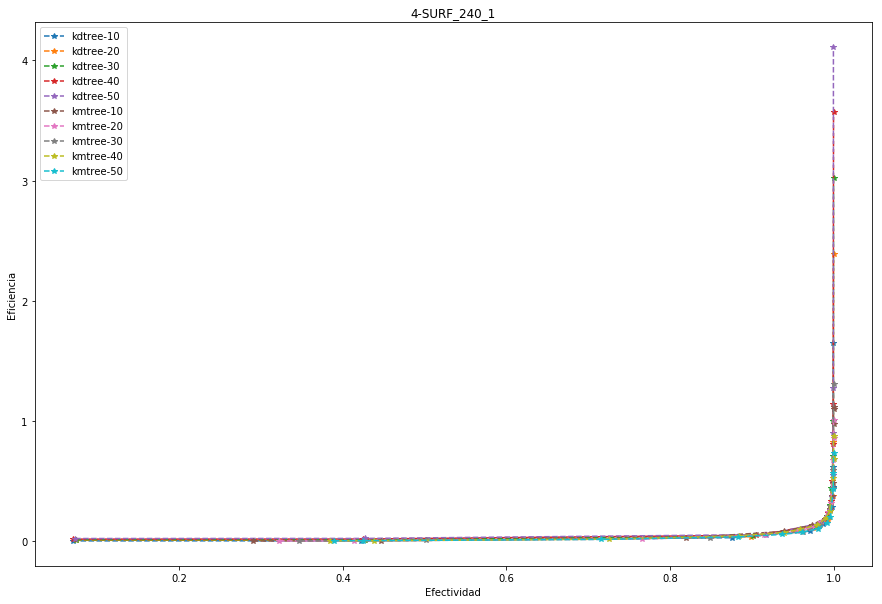

MEJOR CONFIGURACION
Nombre: 4-SURF_240_1
Tipo: kmtree-50
Tiempo de construcción: 1.6935081481933594
Tiempo de búsqueda: 0.7948737144470215
Efeciencia: 0.058277386207963314
Efectividad: 0.9372309401472018
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0073362086180362805


In [365]:
best_configurations.append(show('4-SURF_240_1', kdtrees_7, kmtrees_7))

# Conclusiones

Para 1-IMGRAY-16x9 tenemos que la mejor configuración es un KMeans-Tree con branching 20 y checks 300. Como se puede apreciar en los gráficos, los KM-Trees en general son bastante mejores que los KD-Trees. Comparando los mejores de cada estructura, vemos que el mejor KD-Tree está a una distancia casi 7 veces mayor al óptimo que el mejor KM-Tree.
En cuanto a tiempo de construccíón, también es mejor KM-Tree ya que el mejor se demora la mitad que el mejor KD-Tree.

Para 1-IMGRAY-16x9_AVG tenemos que la mejor configuración es un KMeans-Tree con branching 50 y checks 500. Al igual que en la anterior, en general los KMeans-Trees le ganan en performance a los KD-Trees. Comparando los mejores de cada estructura, nuevamente el mejor KD-Tree está casi a una distancia 7 veces mayor al óptimo que el mejor KM-Tree.
Si consideramos el tiempo de construcción, la mejor opción de cada índice se demoran virtualmente lo mismo en construirse.

Para 2-MEL_16000_80_64_32 tenemos que la mejor configuración es un KMeans-Tree con branching 50 y checks 700. Nuevamente en promedio los KM-Trees son superiores a los KD-Trees en performance. En cuanto a la comparación mejor KMT vesus mejor KDT, el KM-Tree está a la mitad de la distancia al óptimo que el KD-Tree.
En cuanto a tiempo de construcción, el KM-Tree se demora el doble en construirse, pero da el doble de mejor performance, por lo que se podría decir que sigue siendo la mejor opción.

Para 3-ALEXNET_FC7 la mejor opción es un KD-Tree, con 50 trees y checks 1500. En esta ocasión, en general los KD-Tree obtienen mucho mejor performance que los KMeans-Tree. La distancia al óptimo del mejor KD-Tree es un cuarto de la distancia del mejor KMeans-Tree.
En cuanto a la construcción, el mejor KD-Tree se demora alrededor de 15 segundos menos en construirse, por lo que también en ese aspecto es superior.

Para 3-VGG_FC7 la mejor opción es un KD-Tree con 50 trees y checks 1500, al igual que en la anterior. Sin embargo, no hay mayor diferencia con la oṕción de un KMeans-Tree con 50 de branching y 1000 checks.
En cuanto a tiempo de construcción tambien es solo ligramente superior.

Para 4-SIFT_240_1 la mejor opción es un KMeans-Tree con branching 20 y checks 300. La distancia al óptimo es la mitad del mejor KD-Tree.
En cuanto a tiempo de construcción, ambos son virtualmente iguales, por lo que sigue siendo KMeans-Tree superior. Sin embargo, este último se demora la mitad del tiempo en la búsqueda.

Para 4-SURF_240_1 la no hay una clara mejor opción entre un KD-Tree con 10 trees y 300 chekcs y un KMeans-Tree con 50 branching y 500 checks, ya que su distancia euclideana al óptimo es virtualmente igual.
Si tomaramos en cuenta el tiempo de construcción, sería mejor el KD-Tree, ya que toma la casi un tercio del tiempo en construirse.

A continuación se muestran los detalles de cada mejor configuración.

In [366]:
for i in best_configurations:
    print(i)
    print("\n")

Nombre: 1-IMGRAY_16X9
Tipo: kmtree-20
Tiempo de construcción: 2.257634401321411
Tiempo de búsqueda: 0.9545691013336182
Efeciencia: 0.03493974989936114
Efectividad: 0.909457019858353
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.003389744126446868


Nombre: 1-IMGRAY_16X9_AVG
Tipo: kmtree-50
Tiempo de construcción: 3.8618037700653076
Tiempo de búsqueda: 1.2658696174621582
Efeciencia: 0.04202236372510392
Efectividad: 0.9776419941674768
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0022657594778520726


Nombre: 2-MEL_16000_80_64_32
Tipo: kmtree-50
Tiempo de construcción: 2.0660247802734375
Tiempo de búsqueda: 0.9050934314727783
Efeciencia: 0.061005101857160855
Efectividad: 0.9412581585890849
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.00717222638494767


Nombre: 3-ALEXNET_FC7
Tipo: kdtree-50
Tiempo de construcción: 88.77735710144043
Tiempo de búsqueda: 38.892064809799194
Efeciencia: 0.05158713140608579
Efectividad: 0.94